<a href="https://colab.research.google.com/github/michelucci/aadl2-code/blob/master/chapter8/01_Data_exploration_and_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Histology Tissue Classification Project - Data exploration

The goal of this notebook is to first look at the data we have at our disposal. Check which classes we have, if we have unbalanced classes, missing values and so on. This is always the first step in any machine learning project.

## Import needed packages

In [0]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
import cv2

We can check the TensorFlow version we have

In [0]:
tf.__version__

'1.13.1'

## Data exploration
### Helper function for Pandas

In [0]:
def pandas_display():
    """
    Function to setup pandas parameters for interactive session for better display of the DataFrame.

    Returns
    -------
    None
    """

    options = {
        'display': {
            'max_columns': 550,
            'width': 3000,
            'max_colwidth': -1,
            'expand_frame_repr': False,  # Don't wrap to multiple pages
            'max_rows': 200,
            'max_seq_items': 50,         # Max length of printed sequence
            'precision': 4,
            'show_dimensions': False
        },
        'mode': {
            'chained_assignment': None   # Controls SettingWithCopyWarning
        }
    }

    for category, option in options.items():
        for op, value in option.items():
            print('{}.{}'.format(category, op), value)
            pd.set_option('{}.{}'.format(category, op), value)

In [0]:
pandas_display()

display.max_columns 550
display.width 3000
display.max_colwidth -1
display.expand_frame_repr False
display.max_rows 200
display.max_seq_items 50
display.precision 4
display.show_dimensions False
mode.chained_assignment None


### Data extraction

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
base_dir = '/content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000'

In [0]:
{'path': glob(os.path.join(base_dir, '*', '*.tif'))}

In [0]:
df = pd.DataFrame({'path': glob(os.path.join(base_dir, '*', '*.tif'))})

In [0]:
df.head()

path
0  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/5434_CRC-Prim-HE-04_002.tif_Row_451_Col_1351.tif
1  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/626A_CRC-Prim-HE-08_024.tif_Row_451_Col_1.tif   
2  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/148A7_CRC-Prim-HE-04_004.tif_Row_151_Col_901.tif
3  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/6B37_CRC-Prim-HE-08_024.tif_Row_1501_Col_301.tif
4  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/6B44_CRC-Prim-HE-03_010.tif_Row_301_Col_451.tif

In [0]:
df['file_id'] = df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
df['cell_type'] = df['path'].map(lambda x: os.path.basename(os.path.dirname(x))) 
df['cell_type_idx'] = df['cell_type'].map(lambda x: int(x.split('_')[0]))
df['cell_type'] = df['cell_type'].map(lambda x: x.split('_')[1])
df['full_image_name'] = df['file_id'].map(lambda x: x.split('_Row')[0])
df['full_image_row'] = df['file_id'].map(lambda x: int(x.split('_')[-3]))
df['full_image_col'] = df['file_id'].map(lambda x: int(x.split('_')[-1]))

In [0]:
df.head(2)

path                                       file_id cell_type  cell_type_idx              full_image_name  full_image_row  full_image_col
0  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/5434_CRC-Prim-HE-04_002.tif_Row_451_Col_1351.tif  5434_CRC-Prim-HE-04_002.tif_Row_451_Col_1351  DEBRIS    5              5434_CRC-Prim-HE-04_002.tif  451             1351          
1  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/626A_CRC-Prim-HE-08_024.tif_Row_451_Col_1.tif     626A_CRC-Prim-HE-08_024.tif_Row_451_Col_1     DEBRIS    5              626A_CRC-Prim-HE-08_024.tif  451             1

In [0]:
df['image'] = df['path'].map(imread)

In [0]:
df.to_pickle('/content/drive/My Drive/Book2-ch8/data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

reading data from the pkl file

In [0]:
pd.__version__

'0.24.2'

In [0]:
df=pd.read_pickle('/content/drive/My Drive/Book2-ch8/data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

### Checking missing values

There are no missing values in the dataset. This can be easily checked with ```df.isnull()```function.

In [0]:
df.isnull().sum()

path               0
file_id            0
cell_type          0
cell_type_idx      0
full_image_name    0
full_image_row     0
full_image_col     0
image              0
dtype: int64

Let's also check what are the available class labels. We can do that with the ```.unique()```


In [0]:
df.dtypes

path               object
file_id            object
cell_type          object
cell_type_idx      int64 
full_image_name    object
full_image_row     int64 
full_image_col     int64 
image              object
dtype: object

In [0]:
df.memory_usage().sum()

320080

We can also check what is the memory usage of the dataframe. More information can be found here https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.info.html

In [0]:
df.shape

(5000, 8)

We have 5000 images at our disposal in total, for 8 classes.

In [0]:
len(df), len(df.columns)

(5000, 8)

In [0]:
df.shape

(5000, 8)

### Checking if we have imbalanced classes

In [0]:
df['cell_type'].value_counts()

EMPTY      625
ADIPOSE    625
STROMA     625
COMPLEX    625
LYMPHO     625
DEBRIS     625
TUMOR      625
MUCOSA     625
Name: cell_type, dtype: int64

### Checking duplicates

In [0]:
df['full_image_name'][df.duplicated('full_image_name')]

1223    16193_CRC-Prim-HE-05_032.tif
1729    15EA0_CRC-Prim-HE-01_013.tif
2292    140E1_CRC-Prim-HE-06_005.tif
2416    1411C_CRC-Prim-HE-06_005.tif
2492    14AD7_CRC-Prim-HE-06_005.tif
Name: full_image_name, dtype: object

In [0]:
df[df['full_image_name'] == '140E1_CRC-Prim-HE-06_005.tif']['full_image_name']

1894    140E1_CRC-Prim-HE-06_005.tif
2292    140E1_CRC-Prim-HE-06_005.tif
Name: full_image_name, dtype: object

In [0]:
df['full_image_name'][df['full_image_name'].duplicated()].index

Int64Index([1223, 1729, 2292, 2416, 2492], dtype='int64')

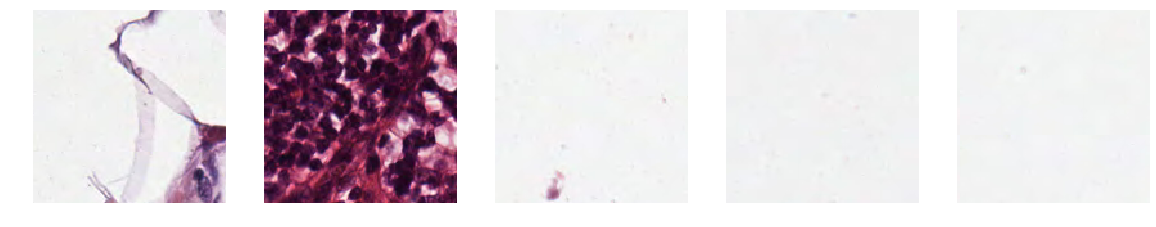

In [0]:
n_samples = 5
fig, m_axs = plt.subplots(1, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, idx in zip(m_axs, df['full_image_name'][df['full_image_name'].duplicated()].index):
    n_axs.imshow(df.iloc[int(idx)]['image'])
    n_axs.axis('off')
    
fig.savefig('/content/drive/My Drive/Book2-ch8/data/duplicated.png')

## Data visualization of some examples

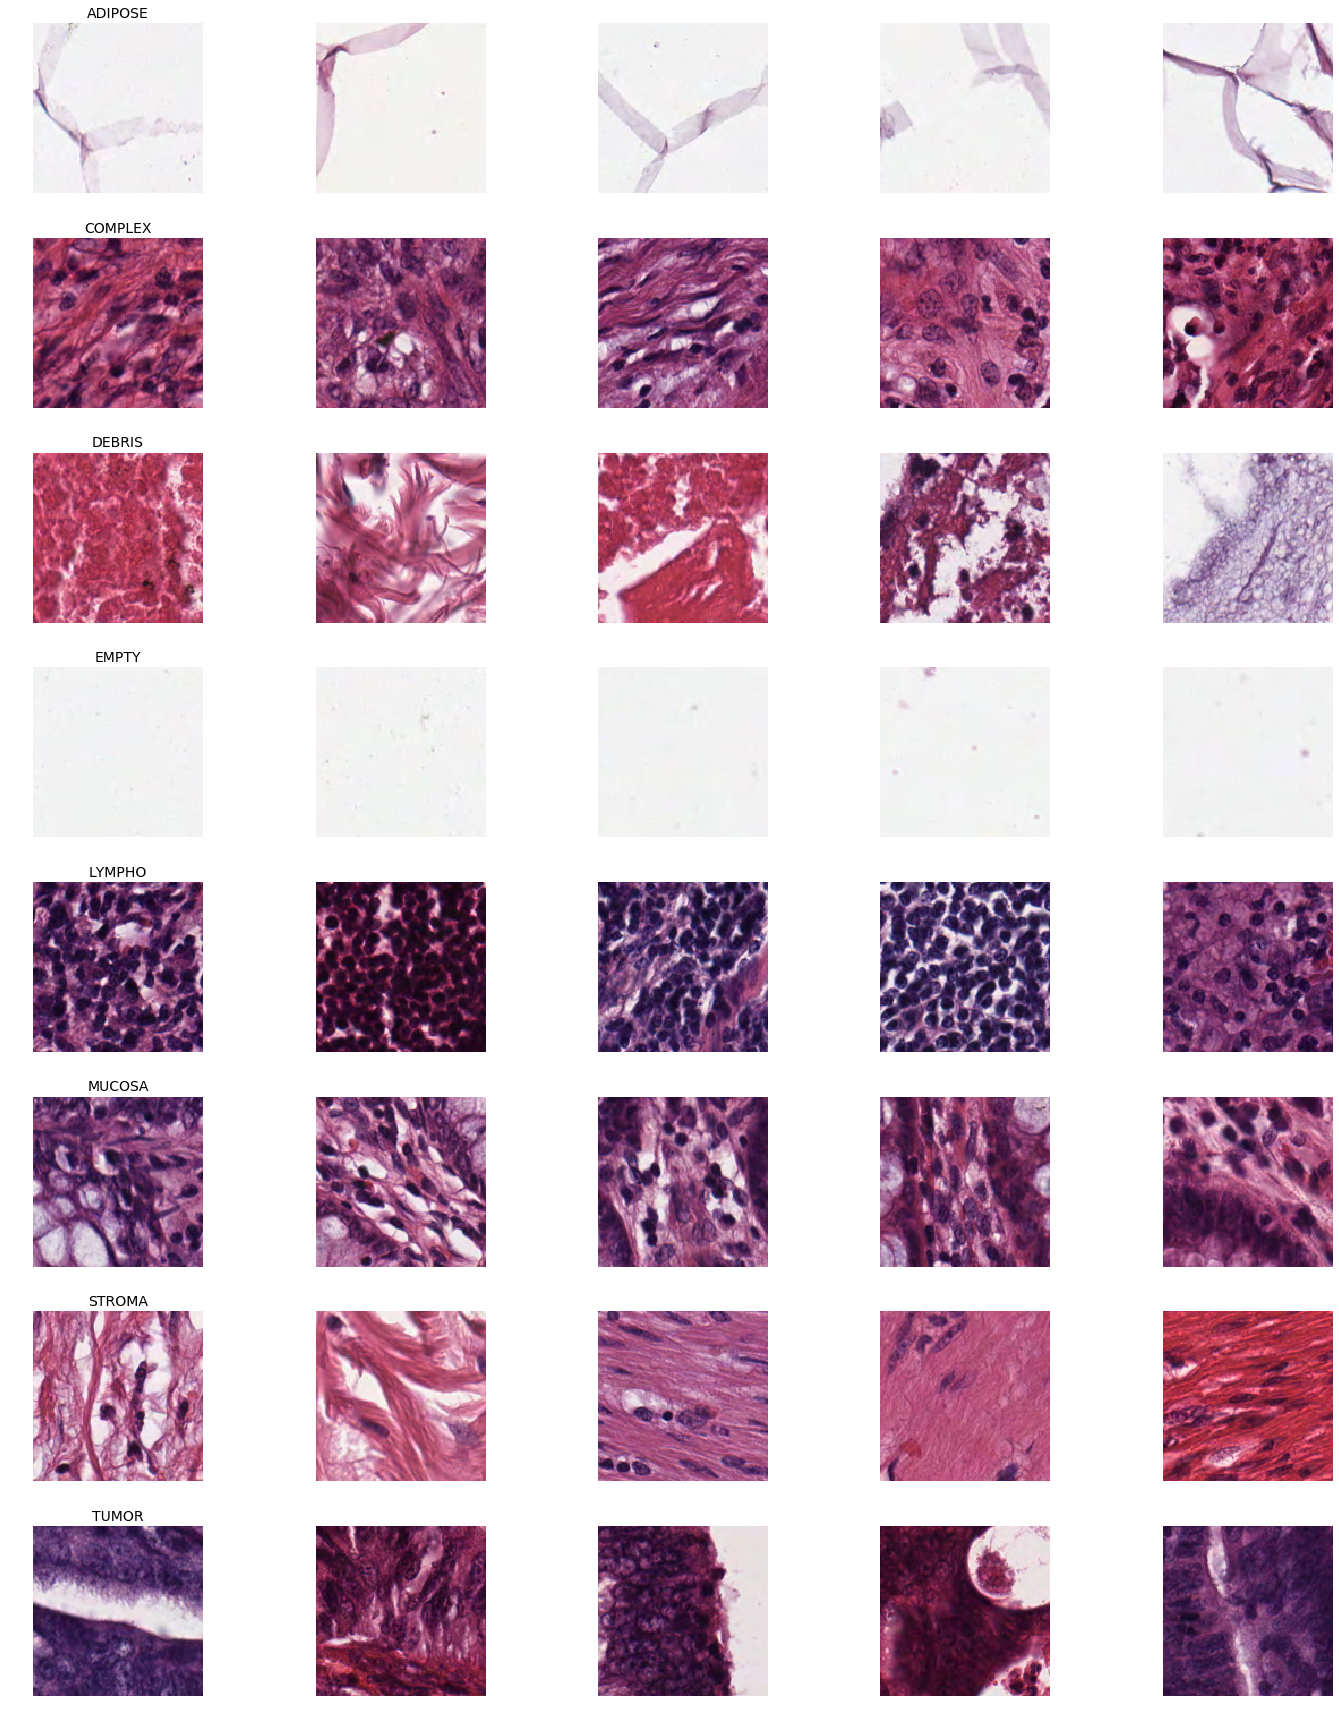

In [0]:
n_samples = 5
fig, m_axs = plt.subplots(8, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name, loc='center', fontsize = 14)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
        
plt.tight_layout()
fig.savefig('/content/drive/My Drive/Book2-ch8/data/examples.png', dpi=300)


In [0]:
df['image'][0].shape

(150, 150, 3)

In [0]:
df['image'][0].dtype

dtype('uint8')

## Reshuffling of the data

In [0]:
df[['path', 'file_id', 'cell_type', 'cell_type_idx', 'full_image_name', 'full_image_row', 'full_image_col']].head(5)

path                                       file_id cell_type  cell_type_idx               full_image_name  full_image_row  full_image_col
0  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/5434_CRC-Prim-HE-04_002.tif_Row_451_Col_1351.tif  5434_CRC-Prim-HE-04_002.tif_Row_451_Col_1351  DEBRIS    5              5434_CRC-Prim-HE-04_002.tif   451             1351          
1  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/626A_CRC-Prim-HE-08_024.tif_Row_451_Col_1.tif     626A_CRC-Prim-HE-08_024.tif_Row_451_Col_1     DEBRIS    5              626A_CRC-Prim-HE-08_024.tif   451             1             
2  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/148A7_CRC-Prim-HE-04_004.tif_Row_151_Col_901.tif  148A7_CRC-Prim-HE-04_004.tif_Row_151_Col_901  DEBRIS    5              148A7_CRC-Prim-HE-04_004.tif  151             901           
3  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/6B37_CRC-Prim-HE-08_024.tif_Row_1501_Col_301.tif  6B37_CRC-Prim-HE-08_024.tif_Row_1501_Col_301  DEBRIS    5              6B37_CRC-Prim-HE-08_024.tif   1501            301           
4  /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/05_DEBRIS/6B44_CRC-Prim-HE-03_010.tif_Row_301_Col_451.tif   6B44_CRC-Prim-HE-03_010.tif_Row_301_Col_451   DEBRIS    5              6B44_CRC-Prim-HE-03_010.tif   301             451

We can easily check that the images are not shuffled by simply checking the index distributions.

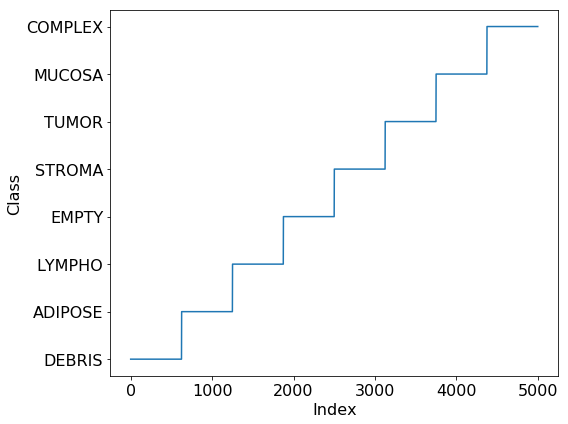

In [0]:
fig = plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Class', fontsize = 16)
plt.tick_params(labelsize=16)
#plt.show()
plt.tight_layout()
fig.savefig('/content/drive/My Drive/Book2-ch8/data/ordered_index.png', dpi = 300)

In [0]:
max(df.index.values), min(df.index.values)

(4999, 0)

In [0]:
import random
rows = df.index.values
random.shuffle(rows)
rows

array([1115, 4839, 3684, ...,  187, 1497, 2375])

In [0]:
max(rows), min(rows)

(4999, 0)

In [0]:
df=df.reindex(rows)
df.sort_index(inplace=True)

Now the indexes are not ordered anymore as it is easy to see from the image.

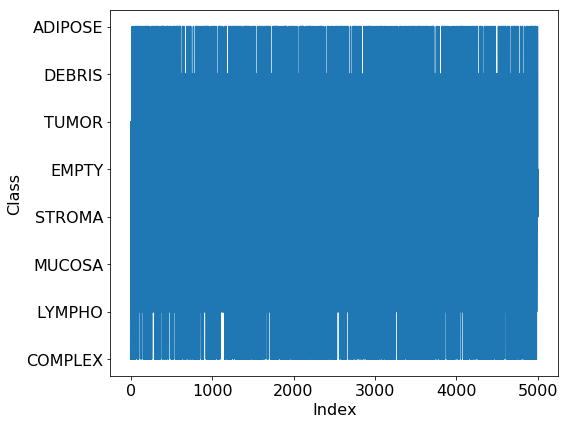

In [0]:
fig = plt.figure(figsize=(8,6))
plt.plot(df.index.values, df['cell_type'])
plt.xlabel('Index', fontsize = 16)
plt.ylabel('Class', fontsize = 16)
plt.tick_params(labelsize=16)
#plt.show()
plt.tight_layout()
fig.savefig('/content/drive/My Drive/Book2-ch8/data/shuffled_index.png')

## Preparing the features and the labels
### One hot encoding of the labels

In [0]:
df_label = pd.get_dummies(df['cell_type'])

In [0]:
df_label.head()

ADIPOSE  COMPLEX  DEBRIS  EMPTY  LYMPHO  MUCOSA  STROMA  TUMOR
0  0        1        0       0      0       0       0       0    
1  0        0        0       0      1       0       0       0    
2  0        0        0       0      0       1       0       0    
3  0        0        0       0      0       0       1       0    
4  0        0        0       1      0       0       0       0

In [0]:
dict_label=list(df_label.columns)
dict_label

['ADIPOSE',
 'COMPLEX',
 'DEBRIS',
 'EMPTY',
 'LYMPHO',
 'MUCOSA',
 'STROMA',
 'TUMOR']

In [0]:
label=df_label.values

In [0]:
label.shape, label.dtype

((5000, 8), dtype('uint8'))

In [0]:
label

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

### Selection of the features: pixels of the images

We need to reshape the images to be able to use them with Keras.

In [0]:
data=np.array(df['image'].tolist())

In [0]:
data.shape, data.dtype

((5000, 150, 150, 3), dtype('uint8'))

## Split Training/Validation/Testing datasets

### Split for Training/Validation/Testing

In [0]:
x, x_test, y, y_test = train_test_split(data, label, test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25,train_size =0.75)

In [0]:
print('1- Training set:', x_train.shape, y_train.shape)
print('2- Validation set:', x_val.shape, y_val.shape)
print('3- Testing set:', x_test.shape, y_test.shape)

1- Training set: (3000, 150, 150, 3) (3000, 8)
2- Validation set: (1000, 150, 150, 3) (1000, 8)
3- Testing set: (1000, 150, 150, 3) (1000, 8)


### Cast of the input pixels

In [0]:
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)
x_val = np.array( x_val, dtype=np.float32)

We can easily check that the max and the min of the pixel values are 255 and 0 respectively.

In [0]:
np.amax(x_train), np.amax(x_test), np.amax(x_val)

(255.0, 255.0, 255.0)

In [0]:
np.amin(x_train), np.amin(x_test), np.amin(x_val)

(0.0, 0.0, 0.0)

### Normalization of the input pixels in the 3 channels

In [0]:
x_train /= 255.0
x_test /= 255.0
x_val /= 255.0

In [0]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_val shape:', x_val.shape)

x_train shape: (3000, 150, 150, 3)
x_test shape: (1000, 150, 150, 3)
x_val shape: (1000, 150, 150, 3)


### Saving the data as pickle files

In [0]:
pickle.dump(x_train, open('/content/drive/My Drive/Book2-ch8/data/x_train.pkl', 'wb'))
pickle.dump(x_test, open('/content/drive/My Drive/Book2-ch8/data/x_test.pkl', 'wb'))
pickle.dump(x_val, open('/content/drive/My Drive/Book2-ch8/data/x_val.pkl', 'wb'))

In [0]:
pickle.dump(y_train, open('/content/drive/My Drive/Book2-ch8/data/y_train.pkl', 'wb'))
pickle.dump(y_test, open('/content/drive/My Drive/Book2-ch8/data/y_test.pkl', 'wb'))
pickle.dump(y_val, open('/content/drive/My Drive/Book2-ch8/data/y_val.pkl', 'wb'))

## Data analyses
### Data distributions

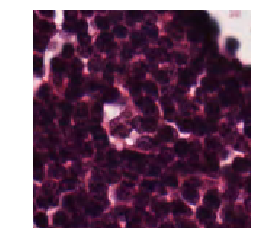

In [0]:
plt.imshow(df['image'][1]);
plt.axis('off')
plt.show()

In [0]:
df.iloc[1]

path               /content/drive/My Drive/Book2-ch8/data/Kather_texture_2016_image_tiles_5000/04_LYMPHO/1533B_CRC-Prim-HE-01_007.tif_Row_1_Col_301.tif                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

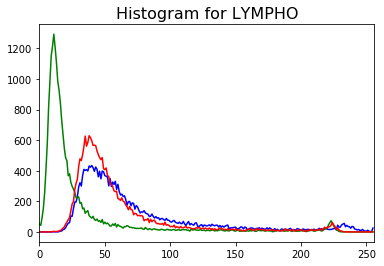

In [0]:
idx = 1
img=df['image'][idx]
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for ' + df.iloc[idx]['cell_type'], fontsize = 16)
plt.show()

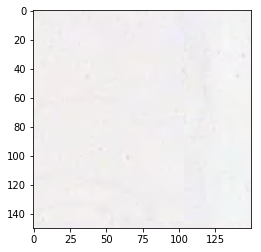

In [0]:
plt.imshow(df['image'][10]);

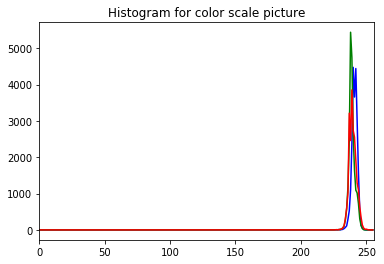

In [0]:
img=df['image'][10]
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

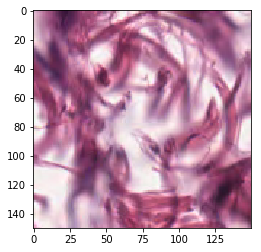

In [0]:
plt.imshow(df['image'][308]);

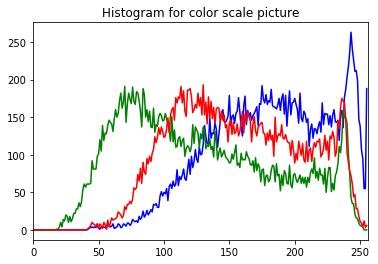

In [0]:
img=df['image'][308]
color = ('b','g','r')
for channel,col in enumerate(color):
    histr = cv2.calcHist([img],[channel],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.title('Histogram for color scale picture')
plt.show()

## Data augmentation Examples

In [0]:
from keras_preprocessing.image import ImageDataGenerator

### Shift images vertically or horizontally by 20%

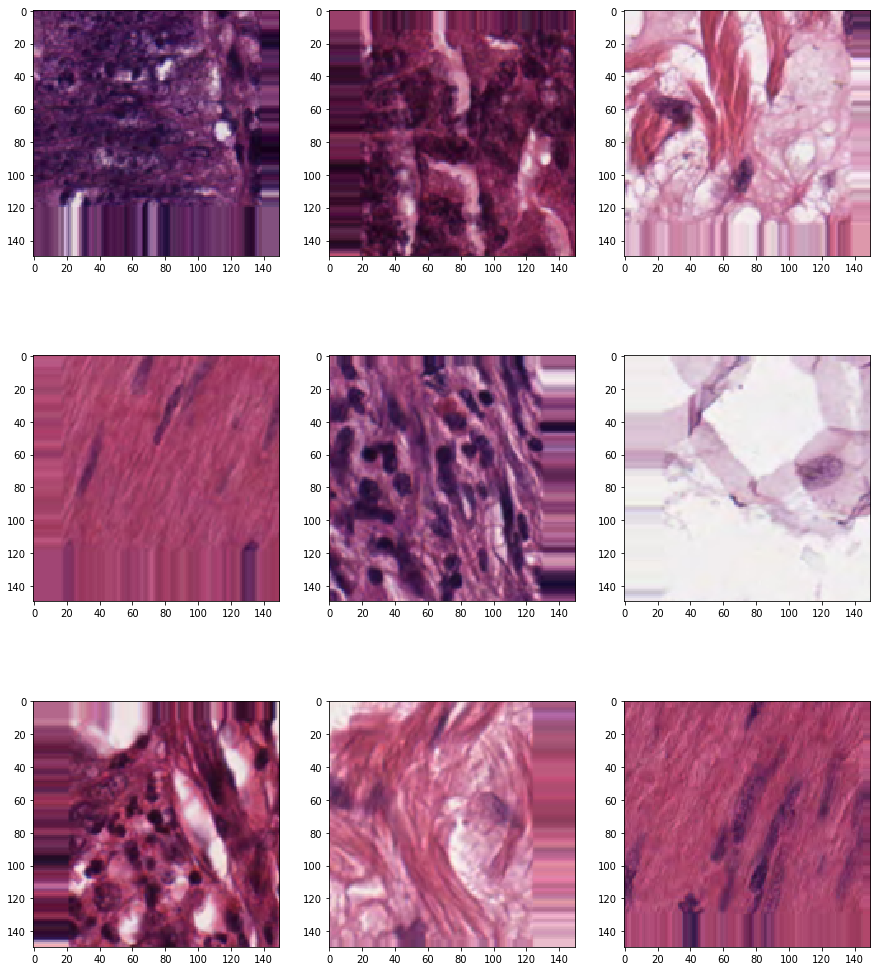

In [0]:
# fill missing pixels with the color of the nearest pixel
datagen = ImageDataGenerator(width_shift_range=.2, 
                             height_shift_range=.2,
                             fill_mode='nearest')

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

### Flip images vertically

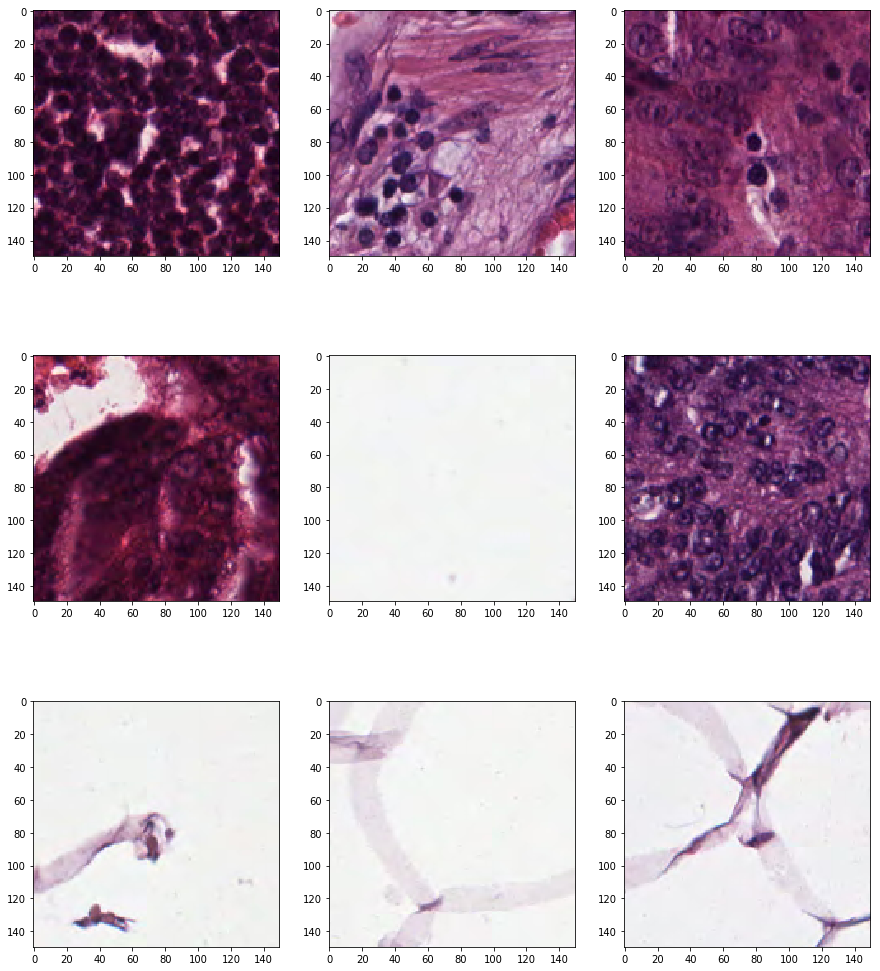

In [0]:
datagen = ImageDataGenerator(vertical_flip=True)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

### Randomly rotate images

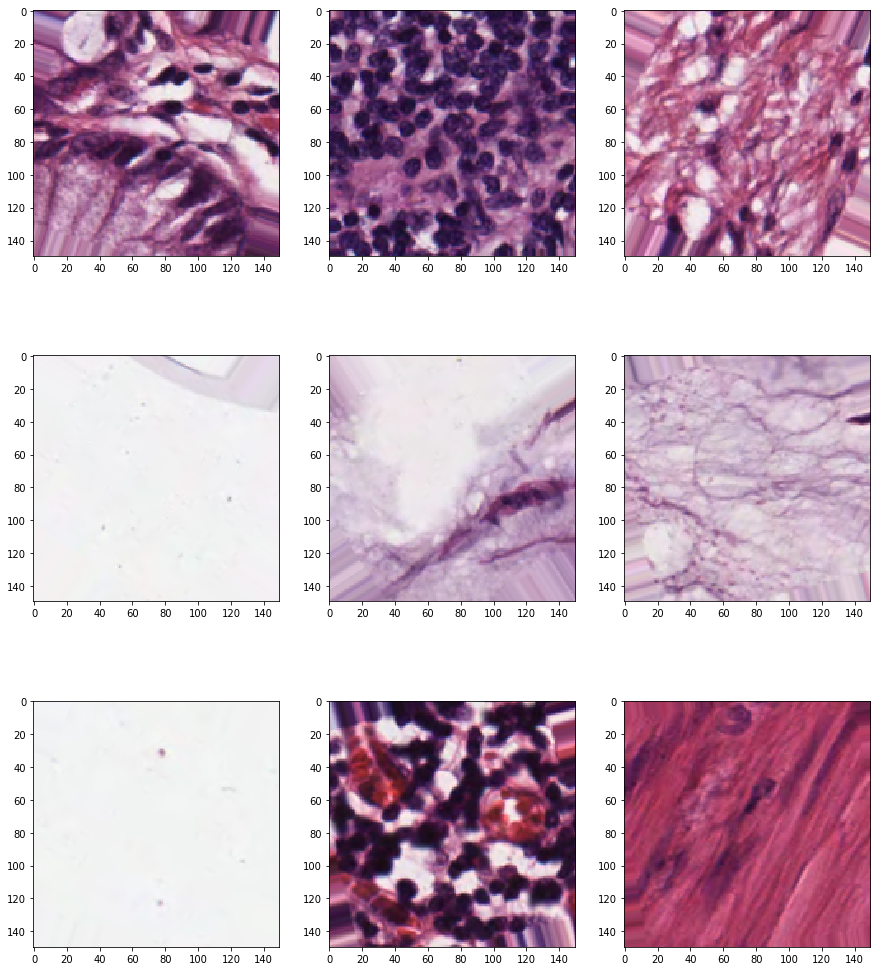

In [0]:
datagen = ImageDataGenerator(rotation_range=90)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

### Zoom in images

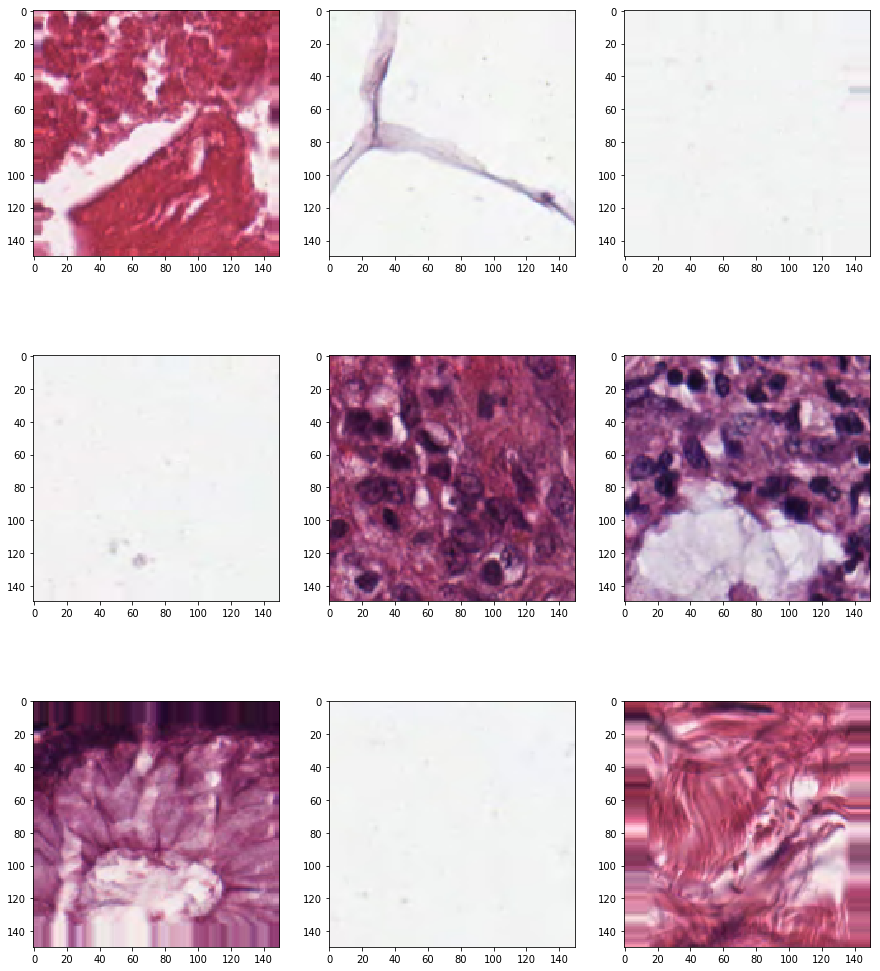

In [0]:
datagen = ImageDataGenerator(zoom_range=0.2)

# fit parameters from data
datagen.fit(x_train)

# Configure batch size and retrieve one batch of images
plt.subplots(3, 3, figsize = (15, 18))             
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break